# Capstone Project 1: Data Wrangling for Machine Learning Analysis

Data source: https://www.yelp.com/dataset.

In this exploration of the yelp restaurants, we will compute some new metrics for the restaurants and categorize them to form the data that will be used in machine learning analysis:
1. Create new column special_category that indicates whether a restaurant is of one of the categories of interest - True or False
2. Create function to compute the number of days between first and last reviews of each restaurant and store the result in new column review_period
3. Create new column review_frequency that is calculated by dividing review_count by review_period then multiplying by 30 to get the number of reviews every 30 days for each restaurant
4. Create function to compute the average change in star rating per 180 day period for each restaurant and store the result in new column change_in_stars
5. Create function to compute the restaurant density within one square km of each restaurant and store the result in new column square_km_count
6. Create function to compute the standard deviation in the star ratings for each restaurant and store the result in new column stars_std
7. Create new dataframe containing the new columns for machine learning analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import datetime as dt
from IPython.core.interactiveshell import InteractiveShell
from math import sin, cos, sqrt, atan2, radians
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings("ignore")

In [2]:
%store -r rests
%store -r goodrv
%store -r modrv
%store -r poorrv

In [3]:
# Concatenate reviews dataframes
reviews = pd.concat([goodrv,modrv,poorrv],ignore_index=True)

In [4]:
# Filter out restaurants that have no review data, leaving 31700 restaurants
rests = rests[rests['business_id'].isin(reviews['business_id'])]

In [5]:
# Make a new column special_category that indicates whether a restaurant is of one of the special categories of interest with True or False
special_categories = ['Vegetarian','Vegan','Dessert','Food Truck','Tacos','Juice','Salad','Coffee','Ramen']
special_category = []
i = 0
for y in rests['categories']:
    special_category.append(False)
    for x in special_categories:
        if x in y:
            special_category[i] = True
            break
    i += 1
        
rests['special_category'] = special_category

In [6]:
reviews = reviews.sort_values('business_id').reset_index(drop=True)
rests = rests.sort_values('business_id').reset_index(drop=True)

In [7]:
# Function to compute review_period - number of days between the last and first reviews
def compute_review_period(x):
    x = x.sort_values('date')
    result = {'review_period': abs((x.iloc[len(x)-1]['date']-x.iloc[0]['date']).days)}
    return pd.Series(result)

In [8]:
# Get the review period in days for each restaurant
review_period = reviews.groupby('business_id').apply(compute_review_period)

In [9]:
# Create new column review_frequency containing the number of reviews per 30 days for each restaurant
rests['review_period'] = review_period['review_period'].tolist()
rests['review_frequency'] = [(c/p)*30 for c,p in zip(rests['review_count'],rests['review_period'])]

In [10]:
# Explore statistics of new column containing continuous values
period_mean = rests['review_period'].mean()
period_std = rests['review_period'].std()
rests['review_period'].min(), period_mean, period_std, rests['review_period'].max()

(7, 2132.77734670704, 1203.7635428026304, 5039)

In [11]:
# Explore statistics of new column containing continuous values
freq_mean = rests['review_frequency'].mean()
freq_std = rests['review_frequency'].std()
rests['review_frequency'].min(), freq_mean, freq_std, rests['review_frequency'].max(), rests['review_frequency'].median()

(0.06976744186046512,
 2.0145163057288356,
 4.244431871772455,
 195.0,
 0.7570977917981072)

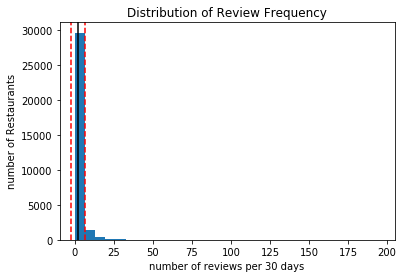

In [12]:
plt.hist(rests['review_frequency'],bins=30)
_ = plt.xlabel('number of reviews per 30 days')
_ = plt.ylabel('number of Restaurants')
_ = plt.title('Distribution of Review Frequency')
_ = plt.axvline(freq_mean, color='k',linestyle='-')
_ = plt.axvline(freq_mean+freq_std,color='r',linestyle='--')
_ = plt.axvline(freq_mean-freq_std,color='r',linestyle='--')
plt.show();

In [13]:
# Create user defined function to calculate the mean star rating every 180 days, and the average change in the mean ratings
def compute_180mean_change(x):
    x = x.sort_values('date')
    stars = list()
    fromd = x.iloc[0]['date']
    means = list()
    lastd = x.iloc[0]['date']
    for s,d in zip(x['stars'],x['date']):
        if abs((d - fromd).days) <= 180:
            stars.append(s)
            lastd = d
        else:
            means.append(np.mean(stars))
            stars = [s]
            fromd = d
            lastd = d
    if stars:
        means.append(np.mean(stars))
    changes = np.diff(means)
    return pd.Series({'change_in_stars':np.mean(changes)})

In [14]:
# Get the average change in mean ratings per 180 day period
change = reviews.groupby('business_id').apply(compute_180mean_change)

In [15]:
# Create new column change_in_stars with the average change in mean ratings per 180 days
rests['change_in_stars'] = change['change_in_stars'].tolist()
rests['change_in_stars'] = rests['change_in_stars'].fillna(0)

In [16]:
# Explore the mean and standard deviations of the new columns containing continuous values
change_mean = np.mean(rests['change_in_stars'])
change_std = np.std(rests['change_in_stars'])
np.min(rests['change_in_stars']), change_mean, change_std, np.max(rests['change_in_stars'])

(-3.6333333333333337, -0.05682996406186319, 0.30067332359706755, 2.75)

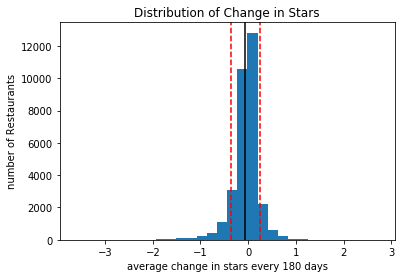

In [17]:
plt.hist(rests['change_in_stars'],bins=30)
_ = plt.xlabel('average change in stars every 180 days')
_ = plt.ylabel('number of Restaurants')
_ = plt.title('Distribution of Change in Stars')
_ = plt.axvline(change_mean, color='k',linestyle='-')
_ = plt.axvline(change_mean+change_std,color='r',linestyle='--')
_ = plt.axvline(change_mean-change_std,color='r',linestyle='--')
plt.show();

In [18]:
# Create user defined function to calculate distance between two restaurants using latitudes and longitudes
def rest_distance(lat1,lon1,lat2,lon2):
    # approximate radius of earth in km
    R = 6378

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance
# create user defined function for getting the restaurant density within one square km of a restaurant
def rest_density(df):
    sqrkm_count = list()
    for lat, lon in zip(df['latitude'],df['longitude']):
        rd = 0
        for x, y in zip(df['latitude'],df['longitude']):
            dist = rest_distance(lat, lon, x, y)
            if 0 < dist <= 1:
                rd += 1
        sqrkm_count.append(rd)
    return pd.Series({'square_km_count': sqrkm_count})

In [19]:
# Get the restaurant density in the square km area of each restaurant location
rests = rests.sort_values(['latitude','longitude','stars','review_count']).reset_index(drop=True)
density = rests.groupby('city').apply(rest_density)

In [20]:
rests['square_km_count'] = density['square_km_count'].tolist()

In [21]:
# Explore the continuous values distribution in square_km_count
den_mean = rests['square_km_count'].mean()
den_std = rests['square_km_count'].std()
rests['square_km_count'].min(), den_mean, den_std, rests['square_km_count'].max()

(0, 73.55374716124149, 115.83872376636022, 716)

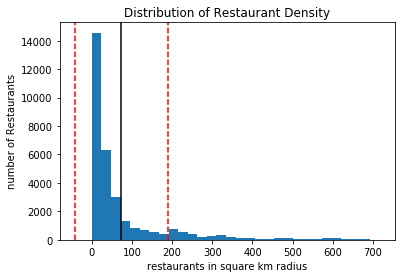

In [22]:
plt.hist(rests['square_km_count'],bins=30)
_ = plt.xlabel('restaurants in square km radius')
_ = plt.ylabel('number of Restaurants')
_ = plt.title('Distribution of Restaurant Density')
_ = plt.axvline(den_mean, color='k',linestyle='-')
_ = plt.axvline(den_mean+den_std,color='r',linestyle='--')
_ = plt.axvline(den_mean-den_std,color='r',linestyle='--')
plt.show();

In [23]:
# Create function to compute ratings volatility in terms of standard deviation in stars over time
def compute_std(x):
    return pd.Series({'stars_std': x['stars'].std()})

In [24]:
# Get the ratings standard deviations
stds = reviews.groupby('business_id').apply(compute_std)

In [25]:
# Create new column stars_std
rests['stars_std'] = stds['stars_std'].tolist()

In [26]:
# Explore the new continous values column
std_mean = rests['stars_std'].mean()
std_std = rests['stars_std'].std()
rests['stars_std'].min(), std_mean, std_std, rests['stars_std'].max()

(0.0, 1.2607388280032847, 0.2624415786796114, 2.088931871468374)

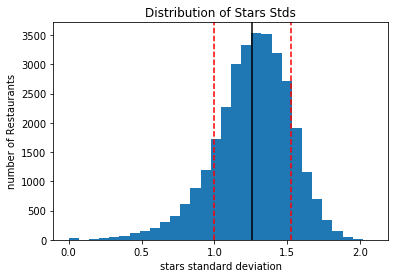

In [27]:
plt.hist(rests['stars_std'],bins=30)
_ = plt.xlabel('stars standard deviation')
_ = plt.ylabel('number of Restaurants')
_ = plt.title('Distribution of Stars Stds')
_ = plt.axvline(std_mean, color='k',linestyle='-')
_ = plt.axvline(std_mean+std_std,color='r',linestyle='--')
_ = plt.axvline(std_mean-std_std,color='r',linestyle='--')
plt.show();

In [28]:
# Create new dataframe to house data that will be used in machine learning analysis
ml = pd.DataFrame(data = {'business_id': rests['business_id'], 
                          'is_open': rests['is_open'],
                          'special_category': rests['special_category'],
                          'review_frequency': rests['review_frequency'],
                          'change_over_time': rests['change_in_stars'],
                          'density': rests['square_km_count'],
                          'volatility': rests['stars_std']})

In [29]:
ml.head()

,business_id,is_open,special_category,review_frequency,change_over_time,density,volatility
0,wF_CCcKxNF3sf6UxFjzXPA,1,False,0.449750,0.153846,1,1.288410
1,47lZIUShHGesiZypN6y7Bw,1,True,0.216606,-0.027778,0,1.354898
2,4sn2a0QzxTmAO3-mxi1s7g,1,False,0.642202,-0.042857,2,1.190238
3,NZP9oypyQCy-IXlzqQWvWQ,1,False,0.183038,0.187500,3,1.517915
4,Fn_IxcCtZl1EoS81sq_s9w,1,False,1.210915,0.000000,1,1.359256


In [30]:
%store ml
%store rests

Stored 'ml' (DataFrame)
Stored 'rests' (DataFrame)
